In [1]:
!pip install -q tensorflow==2.0.0-beta1 tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 87.9MB 49.8MB/s 
     |████████████████████████████████| 348.9MB 81kB/s 
     |████████████████████████████████| 501kB 48.5MB/s 
     |████████████████████████████████| 3.1MB 41.6MB/s 


In [0]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [0]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
download_file_from_google_drive('1dNsQjQYEoGXpX_w7bifHuRxFhlDejwbr','/content/data.zip')

In [0]:
!unzip -q '/content/data.zip'

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=15,
    validation_split =0.2)


test_datagen = ImageDataGenerator(
    rescale=1./255, 
  )


In [8]:
train_generator = train_datagen.flow_from_directory(
    '/content/Dataset/',
    target_size=(28, 28),
    batch_size=128,
    color_mode = 'grayscale',
    shuffle = True,
    class_mode='categorical',
    subset = 'training',
 )

valid_generator = train_datagen.flow_from_directory(
    directory="/content/Dataset/",
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=128,
    class_mode="categorical",
    shuffle=True,
    subset = "validation",
)

Found 19200 images belonging to 24 classes.
Found 4800 images belonging to 24 classes.


In [0]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input,Dense,Dropout
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten

In [0]:
#Network Parameters
input_shape = (28,28,1)
kernel_size = 3
filters = 64
dropout = 0.3

In [0]:
#majorProjectV2.h5
inputs = Input(shape = (28,28,1))
x = Conv2D(filters = 32,
          kernel_size=3,
          strides = (2,2),
          name='Conv1',
          activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = 2)(x)
x= Conv2D(filters = 64,
         kernel_size=2,
         strides=(1,1),
         name='Conv2',
         activation = 'relu')(x)
x=MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
outputs = Dense(24,activation='softmax')(x)
              

In [0]:
model = Model(inputs = inputs, outputs = outputs)

In [36]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 13, 13, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 5, 5, 64)          8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0   

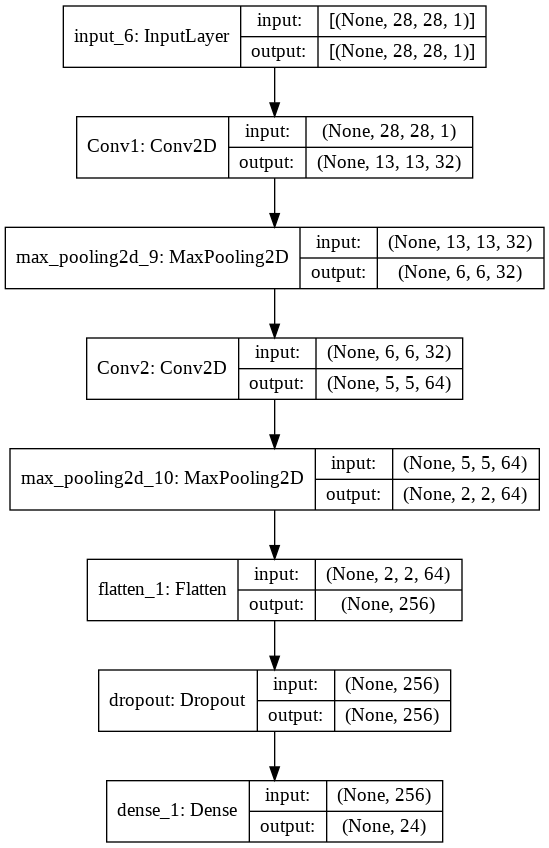

In [37]:
# Convolutional Neural Network
from tensorflow.python.keras.utils import plot_model
plot_model(model, to_file='convolution_neural_network.png',show_shapes = True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-07-31 09:27:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.40.183, 52.72.245.79, 34.200.203.60, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.40.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  37.7MB/s    in 0.3s    

2019-07-31 09:27:57 (37.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
!mkdir log_dir

In [0]:
log_dir='log_dir'

In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [28]:
get_ipython().system_raw('./ngrok authtoken 3B7pn9NBtoPA5qBzWAnxC_MJtkbzVtAKAiSEKrUQKQ &')
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5817367f.ngrok.io


In [0]:
from tensorflow.python.keras.callbacks import TensorBoard

In [0]:
callbacks = [TensorBoard(log_dir, update_freq='batch')]

In [39]:
model.fit_generator(train_generator,epochs = 25, steps_per_epoch=19200//128,validation_steps=4800//128,validation_data=valid_generator, callbacks=callbacks)

Epoch 1/25
150/150 [==============================] - 11s 72ms/step - loss: 2.7729 - accuracy: 0.1973 - val_loss: 1.9918 - val_accuracy: 0.4512
Epoch 2/25
150/150 [==============================] - 10s 66ms/step - loss: 1.6790 - accuracy: 0.4617 - val_loss: 1.4280 - val_accuracy: 0.5553
Epoch 3/25
150/150 [==============================] - 10s 66ms/step - loss: 1.3236 - accuracy: 0.5620 - val_loss: 1.2416 - val_accuracy: 0.6098
Epoch 4/25
150/150 [==============================] - 10s 66ms/step - loss: 1.1620 - accuracy: 0.6103 - val_loss: 1.1220 - val_accuracy: 0.6455
Epoch 5/25
150/150 [==============================] - 10s 66ms/step - loss: 1.0676 - accuracy: 0.6406 - val_loss: 1.0502 - val_accuracy: 0.6603
Epoch 6/25
150/150 [==============================] - 10s 66ms/step - loss: 1.0052 - accuracy: 0.6607 - val_loss: 1.0222 - val_accuracy: 0.6579
Epoch 7/25
150/150 [==============================] - 10s 66ms/step - loss: 0.9463 - accuracy: 0.6749 - val_loss: 0.9552 - val_accuracy:

In [0]:
model.save('majorProjectV2.h5')

In [0]:
from google.colab import drive
drive.mount('/content/drive')